<a href="https://colab.research.google.com/github/resfy/Final_Project/blob/main/Preprocessing-part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENVIRONTMENT PREPARATION

In [ ]:
!pip install mne

     |████████████████████████████████| 7.0MB 5.4MB/s 


In [ ]:
import scipy
import scipy.io as sio
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import math

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pydrive.files import GoogleDriveFile
from google.colab import auth
from oauth2client.client import GoogleCredentials

from mne.preprocessing import ICA

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#VARIABLE DECLARATION

In [ ]:
#range file yang akan diolah
r = 6

#downsampling
#newSfreq = 200

#filter
lfreq= 0
hfreq= 40
transBW_h =2
filt = 'fir'
window = 'blackman'


#epoching
tmin = 0.0
tmax = 0.85

# IMPORTING DATASET FROM GDRIVE
dataset in .mat file is imported as structured numpy array and make it as MNE object.

dataset contains:
1. 21 (2 are reference channels) eeg channels and arranged using 10-20 eeg placement system
2. 1 synchronization channels (X5) for marker and eeg timing synchronization
3. 1 stimulus channels --> marker, stored in 1D array.
4. another information: sampling frequency, sample lenght, subject ID

In [ ]:
#untuk memastikan range dataset didalam list yang akan diolah (tidak dipakai)
for i in range (r):
  print (i)

0
1
2
3
4
5


In [ ]:
# 2. Get .mat File
#gunakan id folder tempat menyimpan dataset
listed = drive.ListFile({'q': "title contains '.mat' and '15wj3fRya057lEmsbTfZY_C3YUFH_h1Ka' in parents"}).GetList()
list_id = []
list_title = []
#get file id and title
for file in listed:
    list_id.append(file['id'])
    list_title.append(file['title'])



In [ ]:
#list title yang berada didalam folder tersebut
#sesuaikan variable range diatas dengan posisi dataset yang akan diolah di list_title
list_title

['5F-SubjectA-160405-5St-SGLHand.mat',
 '5F-SubjectF-160209-5St-SGLHand.mat',
 '5F-SubjectF-151027-5St-SGLHand.mat',
 '5F-SubjectB-160316-5St-SGLHand.mat',
 '5F-SubjectC-151204-5St-SGLHand.mat',
 '5F-SubjectB-151110-5St-SGLHand.mat']

In [ ]:
df = pd.DataFrame()
#load each dataset file
for i in range(r):
    each_file = drive.CreateFile({'id': list_id[i]})
    each_file.GetContentFile(list_title[i])
    df_each_file = sio.loadmat(list_title[i])
    df = df.append(df_each_file, ignore_index=True)

df

,__globals__,__header__,__version__,o
0,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201604051923.D091BB44'], ['NK-data import..."
1,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201602091352.D091BB44'], ['NK-data import..."
2,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201510271827.D091BB44'], ['NK-data import..."
3,[],"b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Crea...",1.0,"[[[['201603161935.D091BB44'], ['NK-data import..."
4,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201512041924.951FEF1D'], ['NK-data import..."
5,[],"b'MATLAB 5.0 MAT-file, Platform: PCWIN, Create...",1.0,"[[[['201511101935.2DE0AC81'], ['NK-data import..."


In [ ]:
#get EEG data from file
file_content = df["o"]
file_content

0    [[[['201604051923.D091BB44'], ['NK-data import...
1    [[[['201602091352.D091BB44'], ['NK-data import...
2    [[[['201510271827.D091BB44'], ['NK-data import...
3    [[[['201603161935.D091BB44'], ['NK-data import...
4    [[[['201512041924.951FEF1D'], ['NK-data import...
5    [[[['201511101935.2DE0AC81'], ['NK-data import...
Name: o, dtype: object

In [ ]:
dataset = []
for subject in file_content.index:
    
  #get channels names
  chnames = []
  for channel in range (len(file_content[subject]['chnames'][0,0])):
    chnames = chnames + [(file_content[subject]["chnames"][0,0][channel][0][0])]

  #get sampling frequency
  sampFreq = (np.hstack((file_content[subject]['sampFreq'][0,0][0])))

  #assign ch_types
  ch_types = ['eeg']*21 + ['misc']

  #make a MNE object
  info_EEG = mne.create_info(chnames,sampFreq,ch_types=ch_types)
  data = file_content[subject]["data"][0,0]
  EEG = mne.io.RawArray(data.transpose(),info_EEG)
  dataset.append(EEG)

  #make digization info (EEG montage configuration)
  montage = mne.channels.make_standard_montage('standard_1020')
  dataset[subject].set_montage(montage)

  #add event marker data
  stim_data = file_content[subject]['marker'][0,0]
  info = mne.create_info(['STI'],dataset[subject].info['sfreq'],['stim'])
  stim_raw = mne.io.RawArray(stim_data.transpose(), info)
  dataset[subject].add_channels([stim_raw], force_update_info=True)

#print MNE object
dataset

Creating RawArray with float64 data, n_channels=22, n_times=718600
    Range : 0 ... 718599 =      0.000 ...  3592.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=718600
    Range : 0 ... 718599 =      0.000 ...  3592.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=718400
    Range : 0 ... 718399 =      0.000 ...  3591.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=718400
    Range : 0 ... 718399 =      0.000 ...  3591.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=736600
    Range : 0 ... 736599 =      0.000 ...  3682.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=736600
    Range : 0 ... 736599 =      0.000 ...  3682.995 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=718800
    Range : 0 ... 718799 =      0.000 ...  3593.995 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=718800
    Range : 0 ... 71

[<RawArray | 23 x 718600 (3593.0 s), ~126.1 MB, data loaded>,
 <RawArray | 23 x 718400 (3592.0 s), ~126.1 MB, data loaded>,
 <RawArray | 23 x 736600 (3683.0 s), ~129.3 MB, data loaded>,
 <RawArray | 23 x 718800 (3594.0 s), ~126.2 MB, data loaded>,
 <RawArray | 23 x 722200 (3611.0 s), ~126.8 MB, data loaded>,
 <RawArray | 23 x 724600 (3623.0 s), ~127.2 MB, data loaded>]

In [ ]:
events = []
for subject in file_content.index:
  event = mne.find_events(dataset[subject], stim_channel='STI')
  events.append(event)

967 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
958 events found
Event IDs: [1 2 3 4 5]
957 events found
Event IDs: [1 2 3 4 5]
967 events found
Event IDs: [ 1  2  3  4  5 91 92 99]
958 events found
Event IDs: [1 2 3 4 5]
958 events found
Event IDs: [1 2 3 4 5]


In [ ]:
#cek lagi judul file yang akan kita olah
title = []
for i in range (r):
  title.append(list_title[i])
title

['5F-SubjectA-160405-5St-SGLHand.mat',
 '5F-SubjectF-160209-5St-SGLHand.mat',
 '5F-SubjectF-151027-5St-SGLHand.mat',
 '5F-SubjectB-160316-5St-SGLHand.mat',
 '5F-SubjectC-151204-5St-SGLHand.mat',
 '5F-SubjectB-151110-5St-SGLHand.mat']

In [ ]:
#beberapa dataset memiliki event yang berbeda, tapi yang akan digunakan hanya id 1 sd 5 aja (jari tangan)
event_dict = {'thumb': 1, 'index': 2, 'middle': 3, 'ring': 4, 'pinky':5}

In [ ]:
for subject in dataset:
   subject.drop_channels('A1')
   subject.drop_channels('A2')
   subject.drop_channels('X5')

#Epoching Raw Data

In [ ]:
#epoching raw EEG
raw_epochs =[]
for subject in file_content.index: 
  epoch = mne.Epochs(dataset[subject], events=events[subject],
                     tmin=tmin,tmax=tmax,event_id=event_dict,baseline=None, 
                     preload=True)
  #resampling hanya untuk dataset yang sfreqnya 1000 Hz
  #epoch.resample(newSfreq)
  raw_epochs.append(epoch)

Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 958 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Loading data for 957 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 958 events and 

In [ ]:
raw_epochs

[<Epochs |  959 events (all good), 0 - 0.85 sec, baseline off, ~25.1 MB, data loaded,
  'index': 172
  'middle': 198
  'pinky': 189
  'ring': 191
  'thumb': 209>,
 <Epochs |  958 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
  'index': 173
  'middle': 198
  'pinky': 188
  'ring': 191
  'thumb': 208>,
 <Epochs |  957 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
  'index': 173
  'middle': 198
  'pinky': 189
  'ring': 191
  'thumb': 206>,
 <Epochs |  959 events (all good), 0 - 0.85 sec, baseline off, ~25.1 MB, data loaded,
  'index': 173
  'middle': 197
  'pinky': 189
  'ring': 191
  'thumb': 209>,
 <Epochs |  958 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
  'index': 202
  'middle': 196
  'pinky': 203
  'ring': 190
  'thumb': 167>,
 <Epochs |  958 events (all good), 0 - 0.85 sec, baseline off, ~25.0 MB, data loaded,
  'index': 192
  'middle': 186
  'pinky': 181
  'ring': 177
  'thumb': 222>]

#Lowpass Filter

In [ ]:
#bandpass filtering to get signal of interest
##create bandpass filter parameter
#visualsisasi parameter filter
filter_params = mne.filter.create_filter(dataset[0].get_data(), dataset[0].info['sfreq'],
                                         l_freq=lfreq, h_freq=hfreq, method=filt, fir_window=window,
                                         h_trans_bandwidth = transBW_h)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 501 samples (2.505 sec)



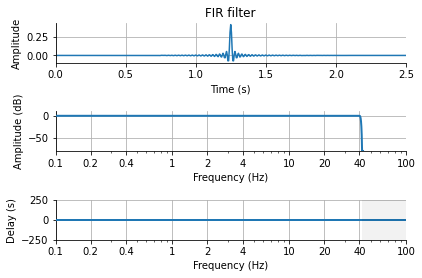

In [ ]:
mne.viz.plot_filter(filter_params, dataset[0].info['sfreq'])
print('\n')

In [ ]:
#filtering the signal
#masih rentang 8-40 hz
for subject in file_content.index :
  dataset[subject].filter(l_freq = lfreq, h_freq = hfreq, picks=None, filter_length='auto',
                          l_trans_bandwidth='auto', h_trans_bandwidth=transBW_h,
                          method=filt,fir_window=window)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 501 samples (2.505 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Blackman window with 0.0017 passband ripple and 74 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 41.00 Hz)
- Filter length: 501 samples (2.505 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter

##Epoching & Downsampling

penting untuk menghilangkan bad epoch, amplituda maksimal eeg = +- 100 uV

In [ ]:
#reject kriteria
#apabila sinyal eeg ada yang lebih dari 100uV dianggap noise dan di hilangkan
#reject_criteria = dict (eeg = 100)

#epoching raw EEG
filtered_epochs =[]
for subject in file_content.index: 
  epoch = mne.Epochs(dataset[subject], events=events[subject],
                     tmin=tmin,tmax=tmax,event_id=event_dict, baseline=None,
                     preload=True)
  #resampling hanya untuk dataset yang sfreqnya 1000 Hz
  #epoch.resample(newSfreq)
  filtered_epochs.append(epoch)


Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 958 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
957 matching events found
No baseline correction applied
0 projection items activated
Loading data for 957 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Loading data for 959 events and 171 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
958 matching events found
No baseline correction applied
0 projection items activated
Loading data for 958 events and 

epoch yang diambil dari t= -2 sekon hingga t=0.75s sesuai dengan rentang waktu terjadinya ERS/ERD.  Tapi di Kaya dkk, dari 0-0.85

#Drop trial with bad SNR

In [ ]:
def dropBadSNR(filtered,drop_indices):
  filtered.drop(drop_indices,reason='badSNR',verbose=None)  

In [ ]:
def calculateSNR(raw_data,filtered_data):
  '''
  input : raw epoch
          filtered epoch

  '''

  raw = raw_data.get_data(picks='eeg')
  filtered = filtered_data.get_data(picks='eeg')

  snrlist=[]
  freq = scipy.fft.rfftfreq(170, 1./200)

  for raw_trial,filtered_trial in zip(raw,filtered):
    temp=[]
    for raw_chan,filtered_chan in zip(raw_trial,filtered_trial):
      #PAKAI FFT AJA
      raw_fft = scipy.fft.rfft(raw_chan)
      filtered_fft = scipy.fft.rfft(filtered_chan)
      noise_fft = raw_fft - filtered_fft
      
      filtered_psd = np.sum(np.abs(filtered_fft)**2)
      noise_psd = np.sum(np.abs(noise_fft)**2)

      #HITUNG PAKAI LOG ==> nilai noisenya kadang ada yg negatif
      #if noise_psd >0:
      snr = filtered_psd/noise_psd
      snr = 10*np.log10(snr)
      temp.append(snr)
            
    snrlist.append(temp)

  return snrlist

In [ ]:
from sklearn import preprocessing
def getgoodSNR(snrlist,filtered_data):

  filtered = filtered_data.get_data(picks='eeg')

  normSNR = snrlist #preprocessing.normalize(snrlist)
  #print(normSNR)

  drop_indices = []
  count = 0

  meansnr = np.mean(snrlist, axis=1)
  Q2 = np.quantile(meansnr,.5,axis=0)
  

  for trialSNR in normSNR:
    #rata2 snr dari semua kanal di masing-masing trial
    chanSNR = np.mean(trialSNR)
  
    if chanSNR< Q2:
      drop_indices.append(count)
    count+=1
  print('count of bad trials :\n',len(drop_indices))
  print('bad trials are :\n',drop_indices)
  if drop_indices is not None:
    goodSNRtrial = dropBadSNR(filtered_data,drop_indices)
  else: 
    goodSNRtrial =filtered

  #return goodSNRtrial

In [ ]:
for raw,filtered in zip(raw_epochs,filtered_epochs):
  snrlist = calculateSNR(raw,filtered)
  goodtrial = getgoodSNR(snrlist,filtered)

count of bad trials :
 479
bad trials are :
 [10, 15, 26, 32, 43, 46, 47, 53, 72, 80, 95, 96, 104, 105, 108, 114, 119, 123, 124, 125, 138, 147, 152, 154, 156, 158, 159, 160, 161, 162, 164, 166, 170, 171, 176, 183, 186, 189, 200, 213, 216, 218, 220, 224, 225, 226, 227, 228, 229, 234, 236, 239, 240, 245, 246, 248, 249, 250, 251, 252, 255, 257, 258, 259, 260, 262, 265, 267, 268, 271, 278, 279, 283, 286, 287, 290, 293, 295, 296, 297, 298, 299, 302, 304, 305, 306, 308, 314, 315, 316, 317, 318, 321, 323, 324, 329, 330, 331, 335, 347, 351, 352, 362, 366, 369, 372, 373, 386, 393, 395, 400, 401, 406, 414, 416, 420, 429, 430, 432, 435, 436, 437, 438, 439, 440, 441, 444, 447, 448, 451, 454, 456, 457, 466, 467, 473, 475, 476, 478, 481, 482, 484, 486, 488, 489, 492, 493, 496, 498, 500, 503, 505, 506, 507, 508, 510, 513, 515, 516, 518, 519, 520, 521, 522, 525, 526, 527, 528, 530, 532, 538, 545, 546, 553, 558, 561, 567, 569, 570, 571, 573, 577, 578, 580, 583, 586, 589, 591, 595, 597, 598, 600, 601, 6

In [ ]:
for dataset in filtered_epochs: 
  print('thumb : ',len(dataset['thumb'].get_data(picks='eeg')))
  print('index : ',len(dataset['index'].get_data(picks='eeg')))
  print('middle : ',len(dataset['middle'].get_data(picks='eeg')))
  print('ring : ',len(dataset['ring'].get_data(picks='eeg')))
  print('pinky : ',len(dataset['pinky'].get_data(picks='eeg')))
  print('\n')


thumb :  89
index :  87
middle :  98
ring :  115
pinky :  91


thumb :  107
index :  83
middle :  97
ring :  90
pinky :  102


thumb :  105
index :  80
middle :  92
ring :  99
pinky :  103


thumb :  83
index :  76
middle :  98
ring :  121
pinky :  102


thumb :  71
index :  92
middle :  112
ring :  109
pinky :  95


thumb :  104
index :  94
middle :  104
ring :  83
pinky :  94




In [ ]:
print(len(snrlist[0]))

19


In [ ]:
a=np.array(snrlist)
print(a.shape)

(958, 19)


In [ ]:
nb=np.mean(snrlist,axis=1)
print(nb[0])

21.960759915955396


#Drop Bad SNR (SNR using scipy.stats.signaltonoise)

In [ ]:
def statsSNR (a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [ ]:
from sklearn import preprocessing
def getgoodSNR2(raw,filtered):

  drop_indices = []
  count = 0
  
  #Q2 = np.quantile(statsSNR(np.abs(trialSNR),axis=1),.5,axis=0)

  for trialSNR in raw:
    snrlist = np.mean(statsSNR(trialSNR,axis=1))
    if snrlist<0:
      drop_indices.append(count)
    count+=1
    #print('snrlist : \n',snrlist)
    #print('stddev : \n', np.std(statsSNR(np.abs(trialSNR),axis=1)))
  print('bad trials are :\n',drop_indices)
  if drop_indices is not None:
    goodSNRtrial = dropBadSNR(filtered,drop_indices)
  else: 
    goodSNRtrial =filtered

  #return goodSNRtrial

In [ ]:
for raw,filtered in zip(raw_epochs,filtered_epochs):
  getgoodSNR2(raw,filtered)

bad trials are :
 [2, 4, 5, 6, 7, 10, 13, 16, 20, 21, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 42, 49, 51, 54, 55, 56, 58, 62, 63, 65, 66, 68, 71, 72, 76, 77, 78, 79, 80, 83, 84, 85, 88, 91, 93, 94, 101, 102, 104, 106, 108, 109, 110, 112, 113, 115, 116, 117, 118, 119, 120, 126, 127, 129, 130, 131, 132, 134, 136, 137, 138, 140, 144, 145, 146, 147, 148, 149, 154, 156, 157, 159, 160, 161, 162, 163, 164, 168, 169, 171, 172, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 188, 189, 192, 193, 195, 197, 199, 200, 202, 204, 205, 207, 208, 209, 210, 212, 215, 216, 217, 218, 219, 221, 222, 223, 226, 227, 231, 232, 233, 234, 235, 239, 241, 242, 243, 244, 247, 248, 250, 251, 254, 255, 257, 258, 259, 265, 270, 274, 275, 277, 285, 286, 287, 288, 293, 297, 298, 300, 301, 302, 303, 305, 306, 312, 313, 314, 316, 318, 320, 321, 322, 324, 325, 326, 327, 329, 333, 334, 335, 336, 337, 340, 341, 342, 343, 344, 346, 347, 350, 352, 354, 355, 357, 358, 360, 361, 362, 363, 364, 366, 367, 368, 371, 372, 373

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


bad trials are :
 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 17, 19, 21, 22, 23, 24, 26, 28, 30, 31, 34, 36, 39, 40, 43, 44, 46, 48, 49, 53, 56, 58, 59, 61, 62, 63, 65, 67, 68, 72, 74, 76, 77, 79, 80, 81, 83, 85, 88, 89, 90, 91, 94, 95, 97, 99, 100, 101, 102, 103, 105, 107, 108, 110, 111, 112, 113, 114, 117, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 135, 136, 138, 140, 141, 146, 147, 148, 149, 151, 153, 154, 155, 156, 157, 158, 162, 164, 165, 167, 170, 171, 172, 173, 174, 176, 178, 183, 188, 189, 190, 191, 194, 196, 197, 198, 199, 200, 201, 202, 203, 205, 207, 208, 210, 211, 212, 213, 214, 216, 217, 218, 221, 222, 224, 226, 228, 230, 233, 234, 236, 237, 238, 239, 240, 242, 243, 244, 245, 246, 247, 248, 250, 252, 253, 254, 256, 258, 259, 260, 261, 264, 267, 268, 269, 270, 272, 274, 275, 279, 281, 282, 284, 287, 292, 295, 296, 298, 300, 301, 304, 306, 307, 310, 312, 314, 315, 318, 320, 321, 322, 323, 324, 326, 331, 333, 335, 337, 342, 344, 348, 350, 351, 352, 354, 355, 357, 359, 361, 36

#SAVE

In [ ]:
split = title[0].split('-')
file_name = split[1] + '-' +  split[2] + '-epo.fif'
filtered_epochs[0].save(file_name, overwrite=True)

In [ ]:
split = title[1].split('-')
file_name = split[1] + '-' +  split[2] + '-epo.fif'
filtered_epochs[1].save(file_name, overwrite=True)

In [ ]:
split = title[2].split('-')
file_name = split[1] + '-' +  split[2] + '-epo.fif'
filtered_epochs[2].save(file_name, overwrite=True)

In [ ]:
split = title[3].split('-')
file_name = split[1] + '-' +  split[2] + '-epo.fif'
filtered_epochs[3].save(file_name, overwrite=True)

In [ ]:
split = title[4].split('-')
file_name = split[1] + '-' +  split[2] + '-epo.fif'
filtered_epochs[4].save(file_name, overwrite=True)

In [ ]:
split = title[5].split('-')
file_name = split[1] + '-' +  split[2] + '-epo.fif'
filtered_epochs[5].save(file_name, overwrite=True)

# MOVE TO FOLDER

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
currentpath = '/content'

In [ ]:
newpath = 'drive/My Drive/preprocessed_EEG/Q2_f'

In [ ]:
import glob, os
import shutil
os.chdir(currentpath)
for file in glob.glob("*.fif"):
  shutil.move(file, newpath)